__Calculation of the Transform limited pulse width and pulse dispersion of fs pulses__

_July 10 Jeroen Korterik_

Pulse dispersion is a phenomenon that occurs in various situations: acoustic pulses (for instance seismic pulses), electric pulses in cables or electric circuits, optical pulses etc.
This document deals with ultrafast (femtosecond) optical pulses but the same principle applies in different situations/fields as well. 

Optical pulses produced can become stretched out in time. 
This means that different wavelengths within the pulse have undergone different delays. This is called pulse dispersion.
As a result, the pulse will be ‘chirped’ : not all wavelengths arrive at the same time at the point of interest (sample or detector). The time resolution of a setup will be compromised to some extent if the pulse is chirped. This can be problematic in data communication where optical pulses get dispersed in optical fibers or for instance in lab experiments like transient absorption spectroscopy and in non-linear optics.
This process of dispersion occurs in lasers/amplifiers/parametric conversions etc. and in general whenever the pulse travels trough dispersive media. For example, when an ultrafast pulse travels through a glass beam splitter cube, the different optical frequencies (wavelengths) travel at different speeds through the glass and therefore the different frequency components have undergone different delays.

Time Bandwidth product (TBP)
The spectral bandwidth of a laser pulse defines the shortest pulse in [s] that can be obtained. This is called the transform limited pulse, there is no pulse dispersion in this case.
The relation is given by a constant, the Time Bandwidth Product (TBP).
The TBP is defined as:

$TBP=\Delta\nu\Delta\tau$

Where $\Delta\nu$ is the FWHM of the spectrum, expressed in [Hz]

and $\Delta\tau$  is the FWHM of the pulse intensity vs. time (assuming a Gaussian intensity vs. time)

The wavelength $\lambda$ can be calculated from frequency f using:

$\lambda=\frac{c}{f}$

where c is the speed of light in the medium (vacuum/air/..).

If we assume that the pulse intensity vs. time is a Gaussian, the TBP is calculated as: 

$TBP_{Gaussian}=\frac{2log2}{\pi}\simeq0.441$

Therefore:
 
$\Delta\nu=\frac{TBP_{Gaussian}}{\Delta\tau}$

And obviously: 

$\Delta\tau=\frac{TBP_{Gaussian}}{\Delta\nu}$

formulas copied from: [https://lasercalculator.com/transform-limited-pulse-calculator/](https://lasercalculator.com/transform-limited-pulse-calculator/)

__Calculation of the TBP__


    

In [3]:
import numpy as np

wavelength=800E-9 #lambda = 1000nm
pulseWidth=35E-15 #gaussian pulseWidth in time for the original pulse NOTE: this is the FWHM of the INTENSITY
c=299792458 #speed of light in vacuum

def calcSpectralWidthFromFormula(pulseWidth,wavelength):
    TBPGaussian=2*np.log(2)/np.pi
    #print("Time Bandwidth product Gaussian constant 2log2/pi= ", TBPGaussian)
    deltaF=TBPGaussian/pulseWidth #widht in [Hz]
    centerFrequency=c/wavelength
    fLow=centerFrequency-deltaF/2
    fHigh=centerFrequency+deltaF/2
    lambdaLow=c/fHigh
    lambdaHigh=c/fLow
    deltaLambda=1E9*(lambdaHigh-lambdaLow)
    print("FWHM spectrum calculated from time bandwidth product: ",f'{deltaLambda:.3}', "[nm]")
    # formula from Transform limited pulse calculator at https://lasercalculator.com/transform-limited-pulse-calculator/ ")

calcSpectralWidthFromFormula(pulseWidth,wavelength)


FWHM spectrum calculated from time bandwidth product:  26.9 [nm]


__Construction of the timetrace__

In [4]:
import matplotlib.pyplot as plt

def gaussian(x, mu, sig, offset=0, ampl=1, use_fwhm=1):
    import numpy as np
    #import math
    if use_fwhm==1:
        fwhm_factor=2*np.sqrt(2*np.log(2) )
        sig=sig/fwhm_factor
    curve=offset+ampl*np.exp(  -np.square(x-mu) / ( 2*np.square(sig) ) )
    return curve

totaltime=3E-12 #total time range in timetrace
timestep=100E-18 #simulation steps in time domain
center=0E-12 #center position in time of the original pulse
fcenter= c / wavelength #the center frequency of the wave 
timeoffset=totaltime/2
numb_points=int(np.floor(totaltime/timestep)+1)
time=np.linspace(0,totaltime,numb_points)
time=time-timeoffset #center of the x axis at time 0
gaussenvelope=np.zeros(numb_points)
timetrace_org=np.zeros((numb_points,), dtype=complex)
exponent=0+1j
use_fwhm=1 # 0 for width=st dev, 1 for width=fwhm
offset=0
amplitude=1

for i,t in enumerate(time):
    gaussenvelope[i]=gaussian(t,center,pulseWidth, offset, amplitude)
    exponent=0+1j*2* np.pi *fcenter*t
    timetrace_org[i]=np.sqrt(gaussenvelope[i])*np.exp(exponent) #amplitude instead of intensity ->sqrt
     

__Calculation of the optical spectrum__

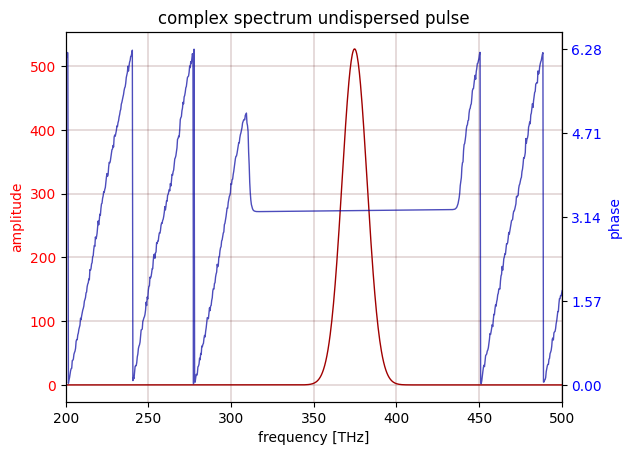

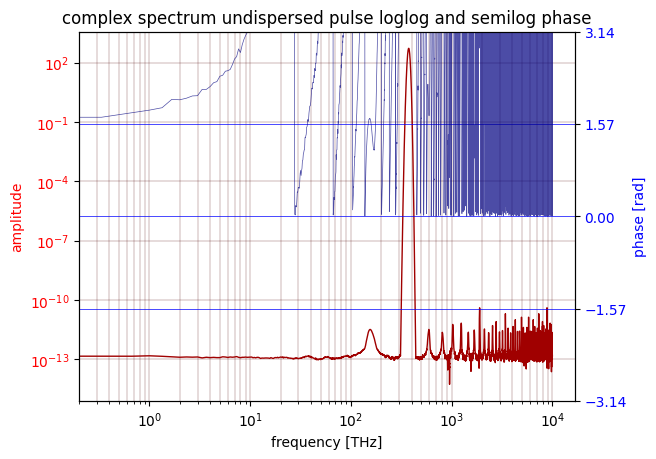

Text(0.5, 1.0, 'spectral intensity vs wavelength')

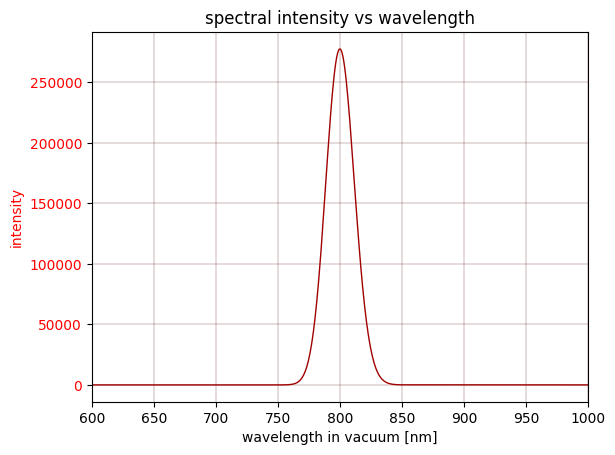

In [5]:
def piShifter(phaseValues):
    for i, phaseValue in enumerate(phaseValues):
        if i%2==0:
            phaseValues[i]=phaseValues[i]-np.pi
        phaseValues[i]=(phaseValues[i])%(2*np.pi) - np.pi
    return phaseValues

"""calculate the complex frequency spectrum from the timetrace------------------"""
complexSpectrum=np.fft.fft(timetrace_org)
frequencyrange=1/timestep
frequencyAxis=np.linspace(0,frequencyrange,numb_points)

""" plot the complex spectrum before dispersion is applied---------------------"""
plt.close('all') #close any previous plots
fig, ax1 = plt.subplots() 
ax1.set_xlabel('frequency [THz]') 
ax1.set_ylabel('amplitude', color = 'red') 
ax1.plot(frequencyAxis/1E12, np.abs(complexSpectrum), linewidth=1.0, color='#A00000') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
plt.grid(True, which="both", ls="-", color='#500000', linewidth = 0.2)
ax1.set(xlim=(200, 500))
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('phase', color = 'blue') 
#ax2.set(ylim=(-4, 4))
y2ticks=[0, np.pi/2, np.pi, np.pi*1.5, np.pi*2, np.pi*2.5, np.pi*3, np.pi*3.5, np.pi*4]
ax2.set_yticks(y2ticks)
phaseValues=piShifter(np.angle(complexSpectrum)) #linear phase shift. This only affects the phase plot, for ease of the eye
#ax2.plot(frequencyAxis, np.angle(complexSpectrum), marker='.', linewidth=1.0, color='#0000A0', alpha=0.7) 
ax2.plot(frequencyAxis/1E12, phaseValues+np.pi, linewidth=1.0, color='#0000A0', alpha=0.7) 
#alpha sets the transparency of the second line so it doesn't obscure the first
ax2.tick_params(axis ='y', labelcolor = 'blue') 
ax2.set_title ("complex spectrum undispersed pulse" )

""" same spectral plot but on log x axis, dual y axis loglog and semilog plot---"""
fig, ax1 = plt.subplots() #init plot  
ax1.set_xlabel('frequency [THz]') 
ax1.set_ylabel('amplitude', color = 'red') 
ax1.plot(frequencyAxis/1E12, np.abs(complexSpectrum), linewidth=1.0, color='#A00000') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
plt.grid(True, which="both", ls="-", color='#500000', linewidth = 0.2)
ax1.semilogx(base=10)
ax1.semilogy(base=10)
#ax1.set(ylim=(0.01, 10))
ax2 = ax1.twinx() 
ax2.set_ylabel('phase [rad]', color = 'blue') 
ax2.set(ylim=(-3.14, 3.14))
y2ticks=[-3.14, -1.57, 0, 1.57, 3.14] #this ticks setting can overrule ylim setting
ax2.set_yticks(y2ticks)
plt.grid(axis = 'y', which='major', color = '#0000FF', linestyle = '-', linewidth = 0.5)
#ax2.plot(frequencyAxis/1E12, np.angle(complexSpectrum), linewidth=0.5, color='#000080', alpha=0.7) 
ax2.plot(frequencyAxis/1E12, phaseValues+np.pi, linewidth=0.5, color='#000080', alpha=0.7) 
#alpha parameter sets the transparency of the second line (ax2) in the plot
ax2.tick_params(axis ='y', labelcolor = 'blue') 
ax2.set_title ("complex spectrum undispersed pulse loglog and semilog phase" )
plt.show()

""" complex spectrum undispersed pulse with wavelength on the x axis--------"""
fig, ax1 = plt.subplots() 
ax1.set_xlabel('wavelength in vacuum [nm]') 
ax1.set_ylabel('intensity', color = 'red') 
ax1.plot(1E9*c/frequencyAxis[1:], np.abs(complexSpectrum[1:])**2, linewidth=1.0, color='#A00000') # first point excluded to prevent div by 0
ax1.tick_params(axis ='y', labelcolor = 'red') 
plt.grid(True, which="both", ls="-", color='#500000', linewidth = 0.2)
ax1.set(xlim=(600, 1000))
ax1.set_title ("spectral intensity vs wavelength" )

__Calculation of the spectral width FWHM from the spectral plot__

In [6]:
from scipy.optimize import curve_fit

def gaussian_fit(x, y):
    mean = sum(x * y) / sum(y) #initial guess x offset gaussion
    sigma = 2.35*np.sqrt(sum(y * (x - mean) ** 2) / sum(y)) #initial gues, factor 2.35 for sigma being the FWHM
    popt, pcov = curve_fit(gaussian, x, y, p0=[mean, sigma, min(y), max(y)])
    return popt

def calcSpectralWidth(frequencyAxis, complexSpectrum):
    peakValue=np.max(np.abs(complexSpectrum)**2)
    print ("peak value intensity: ", peakValue)
    wavelengths=np.zeros(len(frequencyAxis))
    intensities=np.zeros(len(frequencyAxis))
    j=0
    for i, spectralPoint in enumerate(complexSpectrum):
        if np.abs(spectralPoint)>peakValue/1E6:
            wavelengths[j]=1E9*c/frequencyAxis[i]
            intensities[j]=np.abs(spectralPoint)**2
            j=j+1
    mu, sig, offset, ampl = gaussian_fit(wavelengths[0:j-1], intensities[0:j-1])
    #check the gaussian function that is called by the gaussian_fit function
    #variable sig is already expressed as FWHM instead of st dev
    print(" ")
    print ("FWHM spectrum calculated from Fourier transform: ", f'{sig:.3}', "[nm]")


calcSpectralWidth(frequencyAxis, complexSpectrum)
    

peak value intensity:  277570.91912801634
 
FWHM spectrum calculated from Fourier transform:  26.9 [nm]


__Calculation of the dispersed pulse in Fourier space__

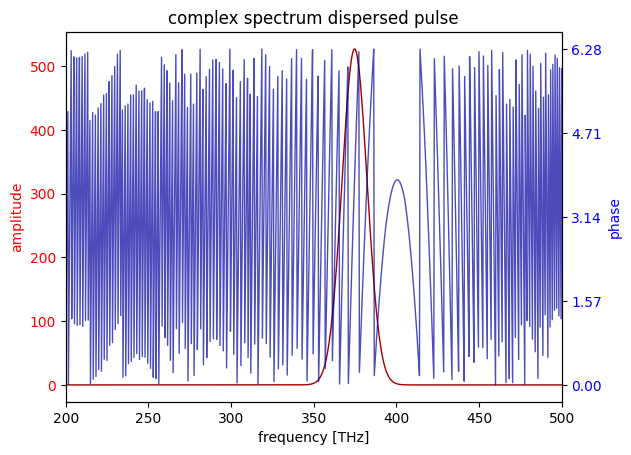

In [7]:
def read_refind_wl(filename): 
    import os
    #path = r"C:\jeroen\python\pulse group velocity dispersion\"
    #path=path.replace("\\", "//")
    #dir_list = os.listdir(path)
    #path+=filename
    path=filename
    lines = []
    wavelengths = []
    refractiveIndices = []
    with open(path) as f:
        lines=f.readlines()
    f.close()
    for i, line in enumerate(lines):
        words = line.split(",")
        wavelength = float (words[0].strip())
        wavelengths.append(wavelength)
        refractiveIndex = float (words[1].strip())
        refractiveIndices.append(refractiveIndex)
    return (wavelengths,refractiveIndices)

thickness=0.02; #thickness of the dispersive medium in [m] 0.02[m] = 20[mm] 
filename='./bk7csv.txt' #keep this txt file in the same folder as this .py script

wavelengths,refractiveIndices=read_refind_wl(filename) 
refrind_freqs=np.divide(c,wavelengths)
refrind_speeds=np.divide(c,refractiveIndices)    
refrind_freqsRev=refrind_freqs[::-1] #reverse 1D array
refrind_speedsRev=refrind_speeds[::-1] #reverse 1D array

speedvals = np.interp(frequencyAxis, refrind_freqsRev, refrind_speedsRev)
for i in range (0,numb_points-1):
    if np.isnan(speedvals[i]):
        speedvals[i]=2E8
delayvals = np.divide(thickness,speedvals)
for i in range (0,numb_points-1): #apply the BK7 phase values
    phasepoint=frequencyAxis[i]*delayvals[i]*2*np.pi
    phasepoint=np.angle(complexSpectrum[i])+phasepoint
    amplpoint=np.abs(complexSpectrum[i])
    exponent=0-1j*phasepoint
    complexSpectrum[i]=amplpoint*np.exp(exponent)

"""plot the complex spectrum after dispersion is applied------------------------"""
fig, ax1 = plt.subplots() 
ax1.set_xlabel('frequency [THz]') 
ax1.set_ylabel('amplitude', color = 'red') 
ax1.plot(frequencyAxis/1E12, np.abs(complexSpectrum), linewidth=1.0, color='#A00000') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
ax1.set(xlim=(200, 500))
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('phase', color = 'blue') 
#ax2.set(ylim=(-4, 4))
y2ticks=[0, np.pi/2, np.pi, np.pi*1.5, np.pi*2, np.pi*2.5, np.pi*3, np.pi*3.5, np.pi*4]
ax2.set_yticks(y2ticks)
phaseValues=piShifter(np.angle(complexSpectrum)) ##linear phase shift. This only affects the phase plot, for ease of the eye
#ax2.plot(frequencyAxis/1E12, np.angle(complexSpectrum), linewidth=1.0, color='#0000A0', alpha=0.7)
ax2.plot(frequencyAxis/1E12, phaseValues+np.pi, linewidth=1.0, color='#0000A0', alpha=0.7)
ax2.set_title ("complex spectrum dispersed pulse" )
#alpha sets the transparency of the second line so it doesn't obscure the first line 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

__Calculate dispersed timetrace from complex spectrum__

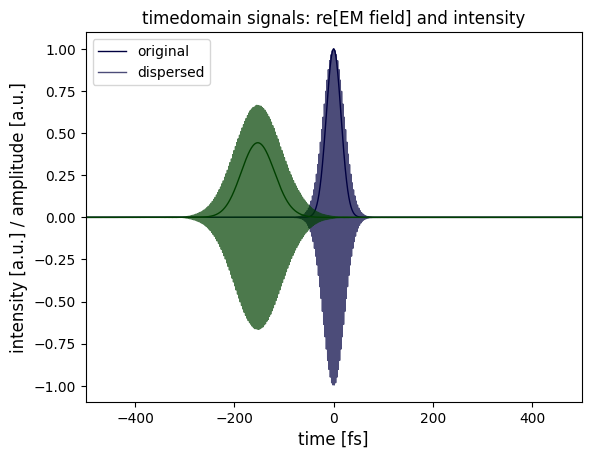

In [15]:
"""calculate the timetrace of the dispersed pulse by inverse fft-----------------"""
timetrace_dispersed=np.fft.ifft(complexSpectrum)
intensity_original=np.square(np.abs(timetrace_org))
intensity_dispersed=np.square(np.abs(timetrace_dispersed))

"""plot the timetrace of original and dispersed pulse-------------------------------"""
fig, ax = plt.subplots() #init plot  
ax.plot(time*1E15, intensity_original, linewidth=1.0, color='#000040', label="original, intensity") 
ax.plot(time*1E15, np.real(timetrace_org), linewidth=1.0, color='#000040', label="original, re(EM)", alpha=0.7) 
ax.plot(time*1E15, intensity_dispersed, linewidth=1.0, color='#004000', label="dispersed, intensity") 
ax.plot(time*1E15, np.real(timetrace_dispersed), linewidth=1.0, color='#004000', label="dispersed, re(EM)", alpha=0.7) 
#ax.plot(time*1E15, np.real(timetrace_org), linewidth=1.0, color='#000040', label="original") 
#ax.plot(time*1E15, np.real(timetrace_dispersed), linewidth=1.0, color='#004000', label="dispersed", alpha=0.7) 
#alpha sets the transparency of the second line so it doesn't obscure the first line 
plt.gca().legend(('original','dispersed'), loc="upper left")
ax.set_xlabel( "time [fs]" , size = 12 )
ax.set_ylabel( "intensity [a.u.] / amplitude [a.u.]" , size = 12 )
ax.set_title ("timedomain signals: re[EM field] and intensity" )
ax.set(xlim=(-500, 500))
plt.show()

__Calculation of the pulse duration FWHM of dispersed and undispersed pulse__

In [16]:
"""apply Gaussian fits to the orignal and dispersed pulse, print FWHM-----------"""
mu, sig, offset, ampl = gaussian_fit(time*1E15, intensity_original)
print ("FWHM original: ", f'{sig:.3}', "[fs]")

mu, sig, offset, ampl = gaussian_fit(time*1E15, intensity_dispersed)
print ("FWHM dispersed: ", f'{sig:.3}', "[fs]")

FWHM original:  35.0 [fs]
FWHM dispersed:  78.8 [fs]
